In [1]:
import pandas as pd
import numpy as np
import graphviz
import pydotplus
import matplotlib.image as mpimg
import io
import random

from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing, tree, datasets
from dtreeviz.trees import dtreeviz

In [2]:
pd.set_option('display.max_rows', 10)
random.seed(24)

Dataset downloaded from https://archive.ics.uci.edu/ml/datasets/wine+quality

In [3]:
df_red_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')
df_white_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', sep=';')

df_red_wine['label'] = 1
df_white_wine['label'] = 0

df_merged_wine = pd.concat([df_red_wine, df_white_wine])
df_merged_wine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,label
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,0
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,0
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,0
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,0


In [4]:
df_merged_wine['label'].value_counts(normalize=True)

0    0.753886
1    0.246114
Name: label, dtype: float64

In [5]:
red_wines = df_merged_wine[df_merged_wine['label'] == 1]
all_white_wines = df_merged_wine[df_merged_wine['label'] == 0]

white_wines = all_white_wines.sample(n=red_wines.shape[0], random_state=24)

df_wine_balanced = pd.concat([red_wines, white_wines])

df_wine_balanced

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,label
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3235,5.7,0.15,0.28,3.7,0.045,57.0,151.0,0.99130,3.22,0.27,11.2,6,0
632,6.9,0.24,0.33,4.8,0.040,16.0,131.0,0.99360,3.26,0.64,10.7,6,0
940,6.2,0.34,0.28,7.5,0.034,40.0,197.0,0.99485,3.14,0.60,9.7,5,0
2384,6.9,0.15,0.28,4.4,0.029,14.0,107.0,0.99347,3.24,0.46,10.4,8,0


In [6]:
df_wine_balanced['label'].value_counts(normalize=True)

1    0.5
0    0.5
Name: label, dtype: float64

In [7]:
def dtree_grid_search(X, y, nfolds):

    param_grid = {'criterion':['gini','entropy'], 
                  'class_weight':['balanced',None], 
                  'splitter':['best','random'], 
                  'max_features':['auto', 'sqrt', 'log2', None], 
                  'max_depth': np.arange(3, 15)}

    dtree_model=DecisionTreeClassifier(random_state=24)
    dtree_gscv = GridSearchCV(dtree_model, param_grid, cv=nfolds)
    dtree_gscv.fit(X, y)
    
    return pd.DataFrame(dtree_gscv.best_params_, index=['Value']).T

In [8]:
X = df_wine_balanced.drop('label', axis=1)
y = df_wine_balanced['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=24)

In [9]:
dtree_grid_search(X_train, y_train, 10)

,Value
class_weight,None
criterion,entropy
max_depth,9
max_features,auto
splitter,best


In [10]:
classifier = tree.DecisionTreeClassifier(class_weight=None, 
                                         criterion='entropy', 
                                         max_depth=3,
                                         max_features='auto', 
                                         splitter='best', 
                                         random_state=24)
model = classifier.fit(X_train, y_train)

In [11]:
model.score(X_test, y_test)

0.9275

In [12]:
df_importances = pd.DataFrame({'feature_importances': classifier.feature_importances_,
                               'feature_names': X_train.columns})
df_importances.sort_values(by='feature_importances', ascending=False)

,feature_importances,feature_names
6,0.604498,total sulfur dioxide
1,0.188027,volatile acidity
4,0.170670,chlorides
9,0.027795,sulphates
2,0.005923,citric acid
...,...,...
3,0.000000,residual sugar
5,0.000000,free sulfur dioxide
7,0.000000,density
10,0.000000,alcohol


In [13]:
classifier.feature_importances_

array([0.        , 0.18802696, 0.0059227 , 0.        , 0.17067   ,
       0.        , 0.604498  , 0.        , 0.00308736, 0.02779498,
       0.        , 0.        ])

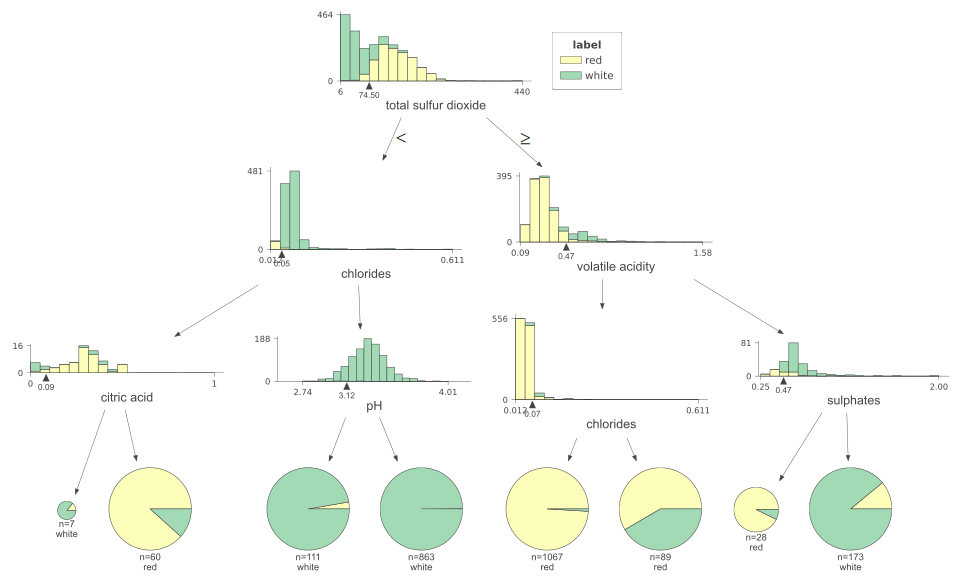

In [14]:
viz = dtreeviz(classifier, 
               X_train, 
               y_train,
               target_name='label',
               feature_names=X.columns.to_list(), 
               class_names=["red", "white"],
               scale=1.4)
              
viz 

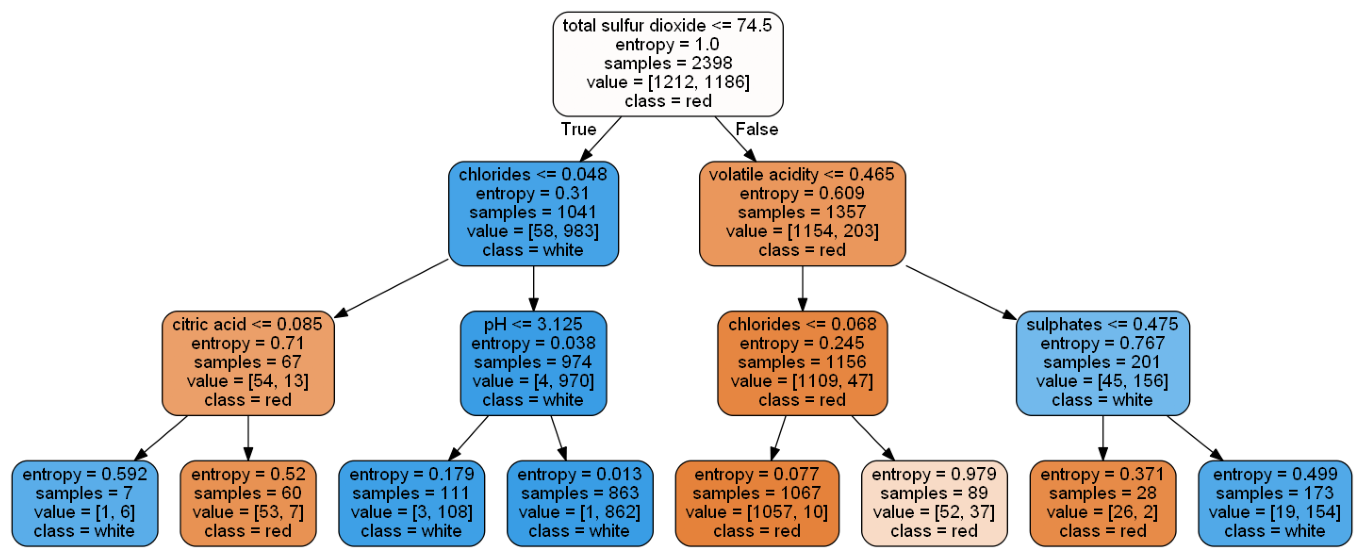

In [15]:
dot_data = io.StringIO()
tree.export_graphviz(classifier, out_file=dot_data, 
                     feature_names=X.columns.to_list(),  
                     filled=True,
                     class_names=['red', 'white'],
                     rounded=True)

filename = "tree.png"
pydotplus.graph_from_dot_data(dot_data.getvalue()).write_png(filename)

plt.figure(figsize=(25,10))
plt.box(False)

img = mpimg.imread(filename)
fig = plt.imshow(img)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

plt.show()

In [16]:
def predict_single_label(fixed_acidity, 
                         volatile_acidity, 
                         citric_acid, 
                         residual_sugar, 
                         chlorides, 
                         free_sulfur_dioxide, 
                         total_sulfur_dioxide, 
                         density, 
                         pH, 
                         suplhates, 
                         alcohol, 
                         quality):
    y_predict = classifier.predict([[fixed_acidity, volatile_acidity, citric_acid, residual_sugar, chlorides, free_sulfur_dioxide, total_sulfur_dioxide, density, pH, suplhates, alcohol, quality]])[0]
    return "red" if y_predict == 1 else "white"

In [17]:
df_wine_balanced.head(1)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,label
0,7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


In [18]:
df_wine_balanced.tail(1)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,label
1150,6.9,0.32,0.17,7.6,0.042,69.0,219.0,0.9959,3.13,0.4,8.9,5,0


In [19]:
predict_single_label(7.4, 0.7, 0.0, 1.9, 0.076, 11.0, 34.0, 0.9978, 3.51, 0.56, 9.4, 5)

'red'

In [20]:
predict_single_label(6.9, 0.32, 0.17, 7.6, 0.042, 69.0, 219.0, 0.9959, 3.13, 0.4, 8.9, 5)

'white'

In [21]:
df_predictions = X_test.copy()
df_predictions['label'] = y_test
df_predictions['predicted_label'] = classifier.predict(X_test)

df_predictions

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,label,predicted_label
23,7.6,0.670,0.14,1.5,0.074,25.0,168.0,0.99370,3.05,0.51,9.3,5,0,1
1562,7.2,0.695,0.13,2.0,0.076,12.0,20.0,0.99546,3.29,0.54,10.1,5,1,1
1270,5.0,0.380,0.01,1.6,0.048,26.0,60.0,0.99084,3.70,0.75,14.0,6,1,1
1569,6.2,0.510,0.14,1.9,0.056,15.0,34.0,0.99396,3.48,0.57,11.5,6,1,1
2792,6.8,0.260,0.44,8.2,0.046,52.0,183.0,0.99584,3.20,0.51,9.4,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40,7.3,0.450,0.36,5.9,0.074,12.0,87.0,0.99780,3.33,0.83,10.5,5,1,0
3676,5.3,0.300,0.30,1.2,0.029,25.0,93.0,0.98742,3.31,0.40,13.6,7,0,0
3764,5.4,0.460,0.15,2.1,0.026,29.0,130.0,0.98953,3.39,0.77,13.4,8,0,0
1303,8.0,0.280,0.44,1.8,0.081,28.0,68.0,0.99501,3.36,0.66,11.2,5,1,1


In [22]:
filter_correct = df_predictions['label'] == df_predictions['predicted_label']
df_predictions_correct = df_predictions.loc[filter_correct]

len(df_predictions.loc[filter_correct]) / len(df_predictions)

0.9275

In [23]:
model.score(X_test, y_test)

0.9275

In [24]:
text_representation = tree.export_text(classifier, feature_names=X.columns.to_list())
print(text_representation)

|--- total sulfur dioxide <= 74.50
|   |--- chlorides <= 0.05
|   |   |--- citric acid <= 0.09
|   |   |   |--- class: 1
|   |   |--- citric acid >  0.09
|   |   |   |--- class: 0
|   |--- chlorides >  0.05
|   |   |--- pH <= 3.12
|   |   |   |--- class: 1
|   |   |--- pH >  3.12
|   |   |   |--- class: 1
|--- total sulfur dioxide >  74.50
|   |--- volatile acidity <= 0.47
|   |   |--- chlorides <= 0.07
|   |   |   |--- class: 0
|   |   |--- chlorides >  0.07
|   |   |   |--- class: 0
|   |--- volatile acidity >  0.47
|   |   |--- sulphates <= 0.47
|   |   |   |--- class: 0
|   |   |--- sulphates >  0.47
|   |   |   |--- class: 1



In [25]:
def predict_single_label_deployed(fixed_acidity, 
                                  volatile_acidity, 
                                  citric_acid, 
                                  residual_sugar, 
                                  chlorides, 
                                  free_sulfur_dioxide, 
                                  total_sulfur_dioxide, 
                                  density, 
                                  pH, 
                                  suplhates, 
                                  alcohol, 
                                  quality,
                                  debug=0):
    if debug==1:
        print(f"fixed_acidity:{fixed_acidity}") 
        print(f"volatile_acidity:{volatile_acidity}")
        print(f"citric_acid:{citric_acid}")
        print(f"residual_sugar:{residual_sugar}")
        print(f"chlorides:{chlorides}")
        print(f"free_sulfur_dioxide:{free_sulfur_dioxide}")
        print(f"total_sulfur_dioxide:{total_sulfur_dioxide}") 
        print(f"density:{density}")
        print(f"pH:{pH}")
        print(f"suplhates:{suplhates}")
        print(f"alcohol:{alcohol}")
        print(f"quality:{quality}")
    
    if total_sulfur_dioxide <= 74.50:
        if chlorides <= 0.05:
            if citric_acid <= 0.09:
                class_=1
            else:
                class_=0
        else:
            if pH <= 3.12:
                class_=1
            else:
                class_=1
    else:
        if volatile_acidity <= 0.47:
            if chlorides <= 0.07:
                class_=0
            else:
                class_=0
        else:
            if sulphates <= 0.47:
                class_=0
            else:
                class_=1
    if class_ == 1:
        return "red"
    else:
        return "white"

In [26]:
predict_single_label_deployed(7.4, 0.7, 0.0, 1.9, 0.076, 11.0, 34.0, 0.9978, 3.51, 0.56, 9.4, 5)

'red'

In [27]:
predict_single_label_deployed(6.9, 0.32, 0.17, 7.6, 0.042, 69.0, 219.0, 0.9959, 3.13, 0.4, 8.9, 5)

'white'